In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Auto print out items w/o using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

# Data Exploration and Visualization using Pandas/Matplotlib
### Use for comparison to Spark DataFrames

### Reviews

In [2]:
pandas_review = pd.read_csv('yelp-dataset/yelp_review.csv')

In [3]:
pandas_review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [4]:
# Find unique values by column 

pandas_review.nunique()

review_id      5261668
user_id        1326101
business_id     174567
stars                5
date              4547
text           5258354
useful             294
funny              255
cool               187
dtype: int64

In [5]:
# See if there are any N/A values in any column and count them 

pandas_review.isnull().sum(axis = 0)

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [6]:
# Determine date range 

print('Start date: ' + pandas_review['date'].min())
print('End date: ' + pandas_review['date'].max())

Start date: 2004-07-22
End date: 2017-12-11


In [7]:
# Find count by year 

year_count = pd.DataFrame(pd.DatetimeIndex(pandas_review['date']).year.value_counts()).sort_index()
year_count

,date
2004,14
2005,870
2006,5669
2007,23020
2008,61553
2009,98288
2010,187073
2011,290933
2012,350381
2013,472595


<BarContainer object of 14 artists>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Review Count per Year')

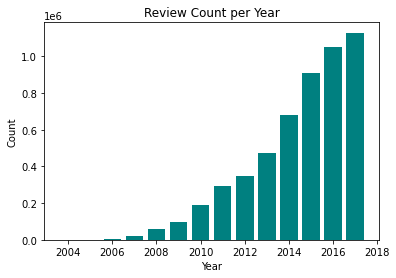

In [8]:
# Plot year counts

plt.bar(year_count.index, year_count['date'], color='teal')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Review Count per Year')
plt.show()

In [9]:
# Count of star reviews 

stars = pd.DataFrame(pandas_review['stars'].value_counts().sort_index())
# stars

<BarContainer object of 5 artists>

Text(0.5, 0, 'Stars')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Review Count per Star Rating')

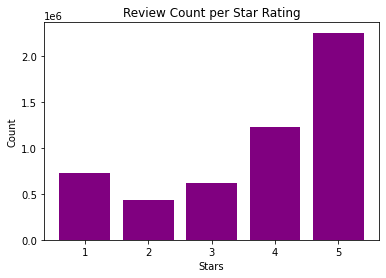

In [10]:
# Plot star reviews count

plt.bar(stars.index, stars['stars'], color='purple')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.title('Review Count per Star Rating')
plt.show()

In [11]:
# Count number of reviews

number_reviews = pandas_review['review_id'].count()
number_reviews

5261668

### Business Attributes

In [12]:
pandas_business_atts = pd.read_csv('yelp-dataset/yelp_business_attributes.csv')
pandas_business_atts.head()

,business_id,AcceptsInsurance,ByAppointmentOnly,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
0,FYWN1wneV18bWNgQjJ2GNg,Na,Na,Na,True,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,He-G7vWjzVUysIKrfNbPUQ,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,8DShNS-LuFqpEWIp0HxijA,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,PfOCPjBrlQAnz__NXj9h_w,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,o9eMRCWt5PkpLDE0gOPtcQ,Na,Na,Na,Na,False,False,False,False,False,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


In [13]:
# See all columns 

pandas_business_atts.columns

Index(['business_id', 'AcceptsInsurance', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'BusinessParking_garage',
       'BusinessParking_street', 'BusinessParking_validated',
       'BusinessParking_lot', 'BusinessParking_valet',
       'HairSpecializesIn_coloring', 'HairSpecializesIn_africanamerican',
       'HairSpecializesIn_curly', 'HairSpecializesIn_perms',
       'HairSpecializesIn_kids', 'HairSpecializesIn_extensions',
       'HairSpecializesIn_asian', 'HairSpecializesIn_straightperms',
       'RestaurantsPriceRange2', 'GoodForKids', 'WheelchairAccessible',
       'BikeParking', 'Alcohol', 'HasTV', 'NoiseLevel', 'RestaurantsAttire',
       'Music_dj', 'Music_background_music', 'Music_no_music', 'Music_karaoke',
       'Music_live', 'Music_video', 'Music_jukebox', 'Ambience_romantic',
       'Ambience_intimate', 'Ambience_classy', 'Ambience_hipster',
       'Ambience_divey', 'Ambience_touristy', 'Ambience_trendy',
       'Ambience_upscale', 'Ambience_casual', 'Restau

### Business Hours

In [14]:
pandas_business_hours = pd.read_csv('yelp-dataset/yelp_business_hours.csv')
pandas_business_hours.head()

,business_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,FYWN1wneV18bWNgQjJ2GNg,7:30-17:0,7:30-17:0,7:30-17:0,7:30-17:0,7:30-17:0,None,None
1,He-G7vWjzVUysIKrfNbPUQ,9:0-20:0,9:0-20:0,9:0-20:0,9:0-20:0,9:0-16:0,8:0-16:0,None
2,KQPW8lFf1y5BT2MxiSZ3QA,None,None,None,None,None,None,None
3,8DShNS-LuFqpEWIp0HxijA,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,11:0-19:0
4,PfOCPjBrlQAnz__NXj9h_w,11:0-1:0,11:0-1:0,11:0-1:0,11:0-1:0,11:0-1:0,11:0-2:0,11:0-0:0


In [15]:
pandas_business_hours.describe()

,business_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday
count,174567,174567,174567,174567,174567,174567,174567,174567
unique,174567,1396,1402,1407,1443,1513,1444,1291
top,AinopkZXEBEzm7Q3vidL1w,None,None,None,None,None,None,None
freq,1,55693,48309,47130,46631,47134,61543,90934


In [16]:
# See if there are any N/A values in any column and count them 

pandas_business_hours.isnull().sum(axis = 0)

business_id    0
monday         0
tuesday        0
wednesday      0
thursday       0
friday         0
saturday       0
sunday         0
dtype: int64

### Business 

In [17]:
pandas_business = pd.read_csv('yelp-dataset/yelp_business.csv')
pandas_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [18]:
# Determine number of missing reviews form this dataframe

missing_reviews = number_reviews - sum(pandas_business['review_count'])
missing_reviews

732

In [19]:
# See if there are any N/A values in any column and count them 

pandas_business.isnull().sum(axis = 0)

business_id          0
name                 0
neighborhood    106552
address              0
city                 1
state                1
postal_code        623
latitude             1
longitude            1
stars                0
review_count         0
is_open              0
categories           0
dtype: int64

In [20]:
# Find number of businesses

pandas_business['business_id'].count()

174567

### Check-In

In [21]:
pandas_checkin = pd.read_csv('yelp-dataset/yelp_checkin.csv')
pandas_checkin.head()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


In [22]:
# See if there are any N/A values in any column and count them 

pandas_checkin.isnull().sum(axis = 0)

business_id    0
weekday        0
hour           0
checkins       0
dtype: int64

In [23]:
pandas_checkin.nunique()

business_id    146350
weekday             7
hour               24
checkins          770
dtype: int64

In [24]:
# Find min and max check-in count

print('Minimum check-in count: ' + str(pandas_checkin['checkins'].min()))
print('Maximum check-in count: ' + str(pandas_checkin['checkins'].max()))

Minimum check-in count: 1
Maximum check-in count: 1478


In [25]:
# FInd number of businesses with 0 check-ins

pandas_business['business_id'].count() - pandas_checkin.nunique()[0]

28217

In [26]:
checkin_day = pd.DataFrame(pandas_checkin['weekday'].value_counts())
checkin_day

,weekday
Sat,653551
Fri,584790
Sun,567181
Thu,545489
Wed,537730
Tue,522104
Mon,500373


<BarContainer object of 7 artists>

Text(0.5, 0, 'Day')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Check-in Count per Day')

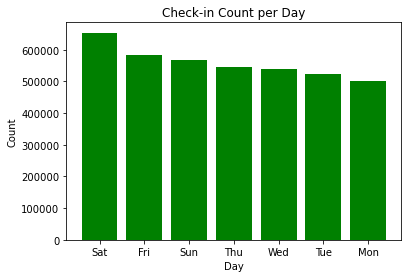

In [27]:
# Plot count per day 

plt.bar(checkin_day.index, checkin_day['weekday'], color='green')
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Check-in Count per Day')
plt.show()

In [28]:
# Find count by hour 

hour_count = pd.DataFrame(pandas_checkin['hour'].value_counts())

<BarContainer object of 24 artists>

Text(0.5, 0, 'Hour')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Check-in Count per Hour')

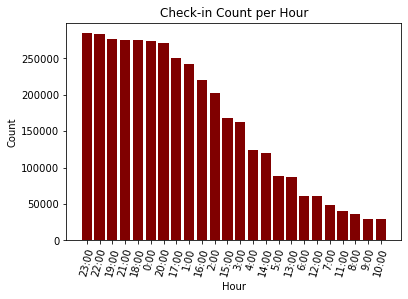

In [29]:
# Plot count by hour 

plt.bar(hour_count.index, hour_count['hour'], color = 'maroon')
plt.xlabel('Hour')
plt.xticks(rotation = 75)
plt.ylabel('Count')
plt.title('Check-in Count per Hour')
plt.show()

### Tip

In [30]:
pandas_tip = pd.read_csv('yelp-dataset/yelp_tip.csv')
pandas_tip.head()

,text,date,likes,business_id,user_id
0,Great breakfast large portions and friendly wa...,2015-08-12,0,jH19V2I9fIslnNhDzPmdkA,ZcLKXikTHYOnYt5VYRO5sg
1,Nice place. Great staff. A fixture in the tow...,2014-06-20,0,dAa0hB2yrnHzVmsCkN4YvQ,oaYhjqBbh18ZhU0bpyzSuw
2,Happy hour 5-7 Monday - Friday,2016-10-12,0,dAa0hB2yrnHzVmsCkN4YvQ,ulQ8Nyj7jCUR8M83SUMoRQ
3,"Parking is a premium, keep circling, you will ...",2017-01-28,0,ESzO3Av0b1_TzKOiqzbQYQ,ulQ8Nyj7jCUR8M83SUMoRQ
4,Homemade pasta is the best in the area,2017-02-25,0,k7WRPbDd7rztjHcGGkEjlw,ulQ8Nyj7jCUR8M83SUMoRQ


In [31]:
# See if there are any N/A values in any column and count them 

pandas_tip.isnull().sum(axis = 0)

text           2
date           0
likes          0
business_id    0
user_id        0
dtype: int64

In [32]:
# Find number of tips 

pandas_tip['text'].count()

1098322

### User 

In [33]:
pandas_user = pd.read_csv('yelp-dataset/yelp_user.csv')
pandas_user.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# See if there are any N/A values in any column and count them 

pandas_user.isnull().sum(axis = 0)

user_id                 0
name                  497
review_count            0
yelping_since           0
friends                 0
useful                  0
funny                   0
cool                    0
fans                    0
elite                   0
average_stars           0
compliment_hot          0
compliment_more         0
compliment_profile      0
compliment_cute         0
compliment_list         0
compliment_note         0
compliment_plain        0
compliment_cool         0
compliment_funny        0
compliment_writer       0
compliment_photos       0
dtype: int64

In [35]:
pandas_user.elite.value_counts()

None                                                          1265282
2017                                                             9148
2016, 2017                                                       3952
2017, 2016                                                       3898
2015, 2017, 2016                                                 1070
                                                               ...   
2017, 2015, 2012, 2016, 2011, 2014, 2013                            1
2016, 2009, 2013, 2014, 2010, 2017, 2012, 2011                      1
2013, 2006, 2012, 2007                                              1
2016, 2007, 2013, 2011, 2014, 2012, 2015, 2017, 2009, 2010          1
2016, 2017, 2011, 2008, 2015, 2013, 2014, 2009, 2010, 2012          1
Name: elite, Length: 8413, dtype: int64

# Spark

## Create Spark Session 

In [36]:
sc = SparkContext("local[*]")
spark = SparkSession(sc)

## Convert Each CSV File into Spark DataFrame
#### And clean the DataFrame if necessary 

### 1. Review

In [37]:
review = spark.read.option("inferSchema",True).csv( "yelp-dataset/yelp_review.csv", header=True)
review.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|  null| null|null|
|Staff was very he...|                   0|                   0|    0|      null|                null|  null| null|null|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|  null| null|null|
|We had their beef...|                null|                null| null|      null|                null|  null| null|null|
|A bit outside of ...|                   0|                   0|    0|      null|                null|  null| null|null|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5

In [38]:
# Print schema and convert data types into pandas DataFrame 

print('Data overview')
review.printSchema()
print('Columns overview')
pd.DataFrame(review.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)

Columns overview


,Column Name,Data type
0,review_id,string
1,user_id,string
2,business_id,string
3,stars,string
4,date,string
5,text,string
6,useful,string
7,funny,string
8,cool,string


In [39]:
# Number of rows in spark dataframe 

review.count()

12454737

In [40]:
pandas_review['text'].count()

5261668

In [75]:
# Show first 5 rows as pandas dataframe. Make sure it read properly as spark dataframe

review.limit(12).toPandas()
# Something is messed up with text column 

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,None,None,None
1,"Staff was very helpful and friendly.""",0,0,0,None,None,None,None,None
2,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,None,None,None
3,We had their beef tartar and pork belly to sta...,None,None,None,None,None,None,None,None
4,A bit outside of downtown montreal but take th...,0,0,0,None,None,None,None,None
5,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,None,None,None
6,The smoked meat is up there in quality and tas...,0,0,0,None,None,None,None,None
7,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,None,None,None
8,The food speaks for itself,so good. Burgers are made to order and the me...,the regular is a 2 patty burger which is twic...,None,None,None,None,None,None
9,Getting the Cajun fries adds a bit of spice to...,0,0,0,None,None,None,None,None


In [66]:
# Show original pandas dataframe from above to compare to the spark dataframe

pandas_review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [74]:
# Print first row of text column to find out the issue 

print(pandas_review['text'][0])
# Found the issue: Spark is seperating the text column into multiple columns where there are spaces

Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. 

Staff was very helpful and friendly.


In [118]:
# One solution could be to delete everything after the first space in the text column of the CSV file
# by deleting rows where user_id, date, text, business_id, stars, and review_id are null
# Also, only get rows where there are less than 2 words
# Then, onyl get rows where date column begins with '20'
# Then, only get rows where the number of characters in user_id, review_id, and business_id are all > 20

# Then the number of rows in the spark dataframe matches number of rows in the pandas dataframe, as seen below 

rev = review.filter(F.size(F.split('review_id', ' ')) < 2)
rev2 = rev.where(col('text').isNotNull())
rev3 = rev2.where(col('date').isNotNull())
rev4 = rev3.where(col('user_id').isNotNull())
rev5 = rev4.where(col('business_id').isNotNull())
rev6 = rev5.where(col('stars').isNotNull())
rev7 = rev6.where(col('review_id').isNotNull())
rev8 = rev7.filter((rev7.date.substr(1,2)) == '20')
review_cleaned = rev8.filter((F.length(rev8.review_id) > 20) & (F.length(rev8.business_id) > 20) & (F.length(rev8.user_id) > 20))

In [121]:
# Verify the fix worked by comparing number of rows between Spark DataFrame and Pandas DataFrame 

review_cleaned.count()

5261668

In [43]:
pandas_review.review_id.count()

5261668

### 2. User

In [123]:
user = spark.read.csv( "yelp-dataset/yelp_user.csv", header=True)

In [124]:
# Show first 5 rows as pandas dataframe. Make sure it read properly as spark dataframe

user.limit(5).toPandas()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0


In [125]:
# Number of rows in spark dataframe 

user.count()

1326100

In [126]:
# Cross check with pandas dataframe 

pandas_user['user_id'].count()

1326100

### 3. Business Attributes

In [130]:
attributes = spark.read.csv( "yelp-dataset/yelp_business_attributes.csv", header=True)

In [131]:
attributes.limit(5).toPandas()

,business_id,AcceptsInsurance,ByAppointmentOnly,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,HairSpecializesIn_coloring,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
0,FYWN1wneV18bWNgQjJ2GNg,Na,Na,Na,True,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,He-G7vWjzVUysIKrfNbPUQ,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,8DShNS-LuFqpEWIp0HxijA,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,PfOCPjBrlQAnz__NXj9h_w,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,o9eMRCWt5PkpLDE0gOPtcQ,Na,Na,Na,Na,False,False,False,False,False,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


In [132]:
attributes.count()

152041

In [128]:
# Cross check with pandas dataframe 

pandas_business_atts['business_id'].count()

152041

### 4. Business Hours 

In [133]:
hours = spark.read.csv( "yelp-dataset/yelp_business_hours.csv", header=True)
hours.show()

+--------------------+----------+----------+----------+----------+----------+----------+---------+
|         business_id|    monday|   tuesday| wednesday|  thursday|    friday|  saturday|   sunday|
+--------------------+----------+----------+----------+----------+----------+----------+---------+
|FYWN1wneV18bWNgQj...| 7:30-17:0| 7:30-17:0| 7:30-17:0| 7:30-17:0| 7:30-17:0|      None|     None|
|He-G7vWjzVUysIKrf...|  9:0-20:0|  9:0-20:0|  9:0-20:0|  9:0-20:0|  9:0-16:0|  8:0-16:0|     None|
|KQPW8lFf1y5BT2Mxi...|      None|      None|      None|      None|      None|      None|     None|
|8DShNS-LuFqpEWIp0...| 10:0-21:0| 10:0-21:0| 10:0-21:0| 10:0-21:0| 10:0-21:0| 10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...|  11:0-1:0|  11:0-1:0|  11:0-1:0|  11:0-1:0|  11:0-1:0|  11:0-2:0| 11:0-0:0|
|o9eMRCWt5PkpLDE0g...|  18:0-0:0|  18:0-0:0|  18:0-0:0|  18:0-0:0|  18:0-0:0|  18:0-0:0|     None|
|kCoE3jvEtg6UVz5SO...|  8:0-17:0|  8:0-17:0|  8:0-17:0|  8:0-17:0|  8:0-17:0|      None|     None|
|OD2hnuuTJ

In [134]:
hours.limit(5).toPandas()

,business_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,FYWN1wneV18bWNgQjJ2GNg,7:30-17:0,7:30-17:0,7:30-17:0,7:30-17:0,7:30-17:0,None,None
1,He-G7vWjzVUysIKrfNbPUQ,9:0-20:0,9:0-20:0,9:0-20:0,9:0-20:0,9:0-16:0,8:0-16:0,None
2,KQPW8lFf1y5BT2MxiSZ3QA,None,None,None,None,None,None,None
3,8DShNS-LuFqpEWIp0HxijA,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,11:0-19:0
4,PfOCPjBrlQAnz__NXj9h_w,11:0-1:0,11:0-1:0,11:0-1:0,11:0-1:0,11:0-1:0,11:0-2:0,11:0-0:0


In [135]:
hours.hours()

174567

In [138]:
# Cross check with pandas dataframe 

pandas_business_hours['business_id'].count()

174567

### 5. Business

In [139]:
business = spark.read.csv( "yelp-dataset/yelp_business.csv", header=True)
business.show()

+--------------------+--------------------+------------------+--------------------+--------------+-------------+-----------+-------------+--------------+------------+------------+-------+--------------------+
|         business_id|                name|      neighborhood|             address|          city|        state|postal_code|     latitude|     longitude|       stars|review_count|is_open|          categories|
+--------------------+--------------------+------------------+--------------------+--------------+-------------+-----------+-------------+--------------+------------+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|"""Dental by Desi...|              null| """4855 E Warner Rd|     Ste B9"""|    Ahwatukee|         AZ|        85044|    33.3306902|-111.9785992|         4.0|     22|                   1|
|He-G7vWjzVUysIKrf...|"""Stephen Szabo ...|              null|"""3101 Washingto...|      McMurray|           PA|      15317|   40.2916853|   -80.1048999|         3.

In [140]:
business.limit(5).toPandas()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""""""Dental by Design""""""",None,"""""""4855 E Warner Rd","Ste B9""""""",Ahwatukee,AZ,85044,33.3306902,-111.9785992,4.0,22,1
1,He-G7vWjzVUysIKrfNbPUQ,"""""""Stephen Szabo Salon""""""",None,"""""""3101 Washington Rd""""""",McMurray,PA,15317,40.2916853,-80.1048999,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""""""Western Motor Vehicle""""""",None,"""""""6025 N 27th Ave","Ste 1""""""",Phoenix,AZ,85017,33.5249025,-112.1153098,1.5,18,1
3,8DShNS-LuFqpEWIp0HxijA,"""""""Sports Authority""""""",None,"""""""5000 Arizona Mills Cr","Ste 435""""""",Tempe,AZ,85282,33.3831468,-111.9647254,3.0,9,0
4,PfOCPjBrlQAnz__NXj9h_w,"""""""Brick House Tavern + Tap""""""",None,"""""""581 Howe Ave""""""",Cuyahoga Falls,OH,44221,41.1195346,-81.4756898,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [142]:
business.count()

174567

In [143]:
pandas_business['business_id'].count()

174567

### 6. Check-in

In [144]:
checkin = spark.read.csv( "yelp-dataset/yelp_checkin.csv", header=True)
checkin.show()

+--------------------+-------+-----+--------+
|         business_id|weekday| hour|checkins|
+--------------------+-------+-----+--------+
|3Mc-LxcqeguOXOVT_...|    Tue| 0:00|      12|
|SVFx6_epO22bZTZnK...|    Wed| 0:00|       4|
|vW9aLivd4-IorAfSt...|    Tue|14:00|       1|
|tEzxhauTQddACyqdJ...|    Fri|19:00|       1|
|CEyZU32P-vtMhgqRC...|    Tue|17:00|       1|
|9dn5pee_n2dWQfN57...|    Sun| 3:00|       5|
|6Zk5F7fsTr8n2CJTl...|    Wed| 1:00|       4|
|OE_IDW5w_W97sBcZv...|    Sat| 1:00|       1|
|gy5pr5bFAjOL5rERS...|    Sat|15:00|       1|
|r2-eAhGANXlcgQy89...|    Mon|19:00|       1|
|wiBxwslJAGDdZ2nmL...|    Mon|16:00|       1|
|08jURVR_eDvXq9scd...|    Sat|23:00|       1|
|BlWPjh2WuvQSlmYmg...|    Sun| 0:00|       1|
|6DO_2jivyxcL6SXGP...|    Wed|23:00|       1|
|wrJROwvVKHvdMVIZO...|    Thu|21:00|       3|
|uU8up3hGwW9qnzQD1...|    Fri| 0:00|       1|
|JHPq9KvMuJaC7CPAT...|    Sun|16:00|       1|
|vyzfT3_KzLi8WmInw...|    Thu| 9:00|       1|
|E4T0rQBJa0e4HIliB...|    Thu|23:0

In [145]:
checkin.limit(5).toPandas()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


In [146]:
checkin.count()

3911218

In [147]:
# Cross check with pandas dataframe 

pandas_checkin['business_id'].count()

3911218

### 7. Tip 

In [148]:
tip = spark.read.csv( "yelp-dataset/yelp_tip.csv", header=True)
tip.show()

+--------------------+----------+-----+--------------------+--------------------+
|                text|      date|likes|         business_id|             user_id|
+--------------------+----------+-----+--------------------+--------------------+
|Great breakfast l...|2015-08-12|    0|jH19V2I9fIslnNhDz...|ZcLKXikTHYOnYt5VY...|
|Nice place. Great...|2014-06-20|    0|dAa0hB2yrnHzVmsCk...|oaYhjqBbh18ZhU0bp...|
|Happy hour 5-7 Mo...|2016-10-12|    0|dAa0hB2yrnHzVmsCk...|ulQ8Nyj7jCUR8M83S...|
|Parking is a prem...|2017-01-28|    0|ESzO3Av0b1_TzKOiq...|ulQ8Nyj7jCUR8M83S...|
|Homemade pasta is...|2017-02-25|    0|k7WRPbDd7rztjHcGG...|ulQ8Nyj7jCUR8M83S...|
|Excellent service...|2017-04-08|    0|k7WRPbDd7rztjHcGG...|ulQ8Nyj7jCUR8M83S...|
|Come early on Sun...|2016-07-03|    0|SqW3igh1_Png336VI...|ulQ8Nyj7jCUR8M83S...|
|    Love their soup!|2016-01-07|    0|KNpcPGqDORDdvtekX...|ulQ8Nyj7jCUR8M83S...|
|Soups are fantastic!|2016-05-22|    0|KNpcPGqDORDdvtekX...|ulQ8Nyj7jCUR8M83S...|
|Thursday night 

In [149]:
tip.limit(5).toPandas()

,text,date,likes,business_id,user_id
0,Great breakfast large portions and friendly wa...,2015-08-12,0,jH19V2I9fIslnNhDzPmdkA,ZcLKXikTHYOnYt5VYRO5sg
1,Nice place. Great staff. A fixture in the tow...,2014-06-20,0,dAa0hB2yrnHzVmsCkN4YvQ,oaYhjqBbh18ZhU0bpyzSuw
2,Happy hour 5-7 Monday - Friday,2016-10-12,0,dAa0hB2yrnHzVmsCkN4YvQ,ulQ8Nyj7jCUR8M83SUMoRQ
3,"Parking is a premium, keep circling, you will ...",2017-01-28,0,ESzO3Av0b1_TzKOiqzbQYQ,ulQ8Nyj7jCUR8M83SUMoRQ
4,Homemade pasta is the best in the area,2017-02-25,0,k7WRPbDd7rztjHcGGkEjlw,ulQ8Nyj7jCUR8M83SUMoRQ


In [150]:
tip.count()

1130231

In [151]:
# Cross check with pandas dataframe 

pandas_tip['text'].count()

1098322

In [ ]:
### Do we want to do anything with this DataFrame? I do not want to clean it. 